mallorn-astronomical-classification-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)

Files in data directory:
['split_13', 'train_log.csv', 'split_05', 'split_17', 'split_10', 'split_06', 'split_18', 'test_log.csv', 'split_16', 'split_04', 'split_08', 'split_03', 'split_09', 'split_07', 'split_11', 'sample_submission.csv', 'split_20', 'split_19', 'split_12', 'split_15', 'split_01', 'split_02', 'split_14']
Train Shape: (3043, 8)
Test Shape: (7135, 7)

Detected ID Column: object_id
Detected Target Column: target


,object_id,Z,Z_err,EBV,SpecType,English Translation,split,target
0,Dornhoth_fervain_onodrim,3.0490,NaN,0.110,AGN,Trawn Folk (Dwarfs) + northern + Ents (people),split_01,0
1,Dornhoth_galadh_ylf,0.4324,NaN,0.058,SN II,Trawn Folk (Dwarfs) + tree + drinking vessel,split_01,0
2,Elrim_melethril_thul,0.4673,NaN,0.577,AGN,Elves + lover (fem.) + breath,split_01,0
3,Ithil_tobas_rodwen,0.6946,NaN,0.012,AGN,moon + roof + noble maiden,split_01,0
4,Mirion_adar_Druadan,0.4161,NaN,0.058,AGN,"jewel, Silmaril + father + Wild Man",split_01,0


--- Summary Statistics ---


,Z,Z_err,EBV,target
count,3043.000000,0.0,3043.000000,3043.000000
mean,0.670674,NaN,0.055547,0.048636
std,0.539269,NaN,0.061349,0.215142
min,0.008771,NaN,0.002000,0.000000
25%,0.317750,NaN,0.020000,0.000000
50%,0.481800,NaN,0.037000,0.000000
75%,0.883550,NaN,0.069000,0.000000
max,4.924000,NaN,0.758000,1.000000



Total Missing Values: 3043


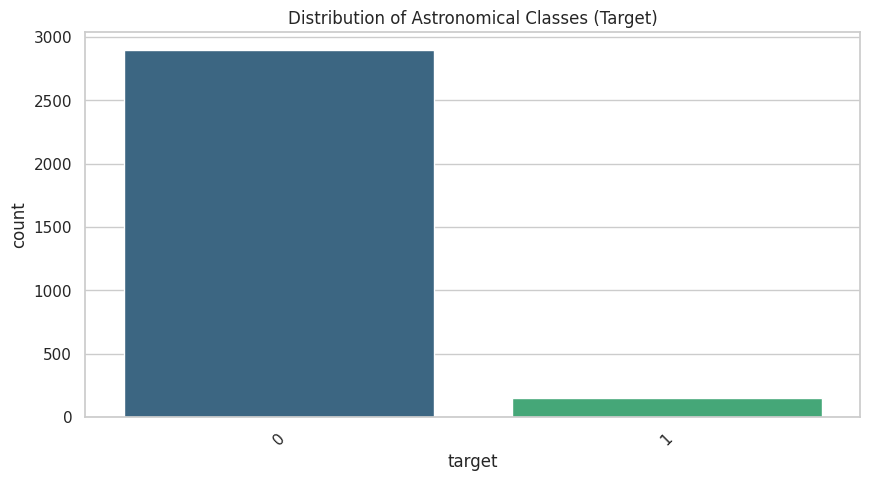

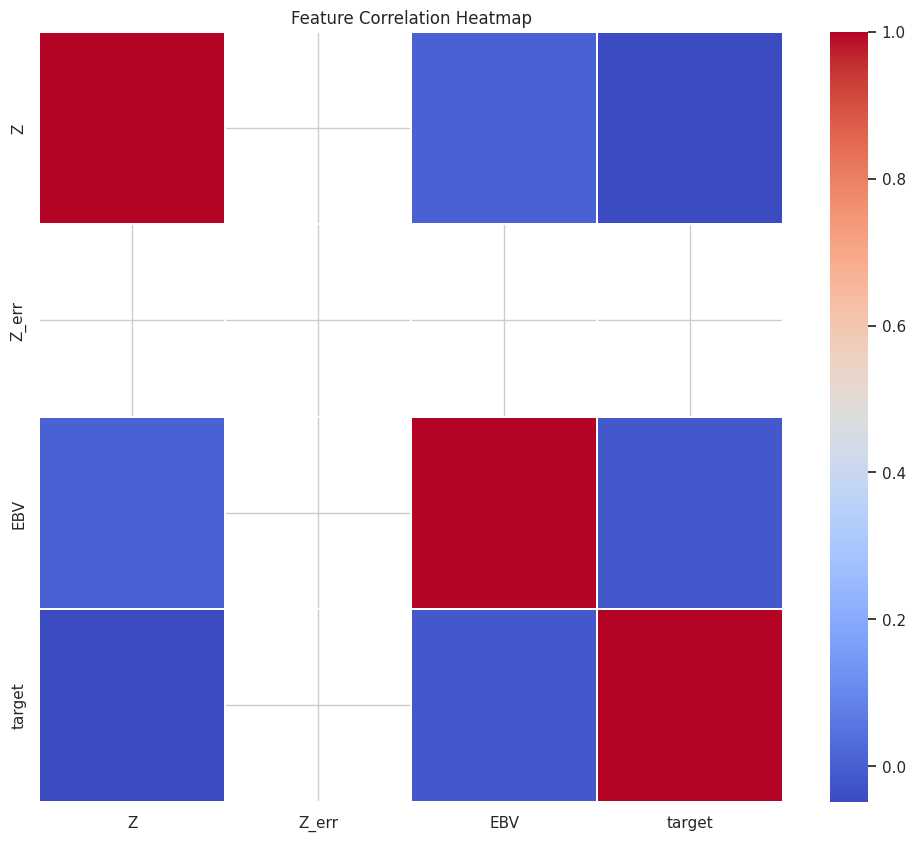

Dropped 'Z_err' column from both train and test sets as it was entirely NaN in the training set.
Features after processing: ['EBV', 'English Translation', 'SpecType', 'Z', 'split']
Preprocessing complete. Training size: 2434, Validation size: 609
Training Baseline: Logistic Regression...
Logistic Regression Accuracy: 0.9984

Training Advanced Model: XGBoost...
XGBoost Accuracy: 1.0000

--- Classification Report (XGBoost) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       579
           1       1.00      1.00      1.00        30

    accuracy                           1.00       609
   macro avg       1.00      1.00      1.00       609
weighted avg       1.00      1.00      1.00       609

Starting Hyperparameter Tuning (this may take a few minutes)...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.2}
Tuned XGBoost Accuracy: 1

,object_id,target
0,Eluwaith_Mithrim_nothrim,1
1,Eru_heledir_archam,1
2,Gonhir_anann_fuin,1
3,Gwathuirim_haradrim_tegilbor,1
4,achas_minai_maen,1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# Install libraries if not already present (Colab usually has most)
!pip install -q pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm

import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and Evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

# Settings
%matplotlib inline
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')
from google.colab import files

# 2.1 Upload kaggle.json
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Please upload your kaggle.json file:")
    uploaded = files.upload()

    # 2.2 Create the ~/.kaggle directory
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/

    # 2.3 Set permissions
    !chmod 600 ~/.kaggle/kaggle.json
    print("Kaggle API token configured.")

# 2.4 Download the competition dataset
COMPETITION_NAME = 'mallorn-astronomical-classification-challenge'

!kaggle competitions download -c {COMPETITION_NAME}

# 2.5 Unzip the dataset into /content/data
DATA_DIR = '/content/data'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

with zipfile.ZipFile(f"{COMPETITION_NAME}.zip", 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR)

# 2.6 Print directory structure
print("\nFiles in data directory:")
print(os.listdir(DATA_DIR))
# Load data
train_path = os.path.join(DATA_DIR, 'train_log.csv')
test_path = os.path.join(DATA_DIR, 'test_log.csv')

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")

# Identify columns (Adjusting for standard naming if specific names vary)
# Usually, astronomical challenges use 'id' or 'object_id' and 'target' or 'class'
target_col = 'target' if 'target' in train_df.columns else train_df.columns[-1]
id_col = 'id' if 'id' in train_df.columns else train_df.columns[0]

print(f"\nDetected ID Column: {id_col}")
print(f"Detected Target Column: {target_col}")

display(train_df.head())
# 4.1 Basic Statistics
print("--- Summary Statistics ---")
display(train_df.describe())

# 4.2 Missing Value Analysis
missing_values = train_df.isnull().sum().sum()
print(f"\nTotal Missing Values: {missing_values}")

# 4.3 Target Distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=target_col, data=train_df, palette='viridis')
plt.title('Distribution of Astronomical Classes (Target)')
plt.xticks(rotation=45)
plt.show()

# 4.4 Correlation Heatmap (Numeric Features Only)
plt.figure(figsize=(12, 10))
numeric_cols_for_corr = train_df.select_dtypes(include=[np.number]).columns
correlation = train_df[numeric_cols_for_corr].corr()
sns.heatmap(correlation, annot=False, cmap='coolwarm', linewidths=0.1)
plt.title('Feature Correlation Heatmap')
plt.show()
# Separate features and target
X = train_df.drop([id_col, target_col], axis=1)
y = train_df[target_col]
X_test = test_df.drop([id_col], axis=1)

# 5.1 Encode Target if it's categorical
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

# --- Start of fix for handling missing values and categorical features ---

# Handle 'Z_err' column: it's entirely NaN in the training set (from train_df.describe()).
# If a feature is entirely NaN in training data, it provides no information.
# To ensure consistent columns between X and X_test for subsequent steps,
# we drop 'Z_err' from both if it's all NaN in the training set.
if 'Z_err' in X.columns and X['Z_err'].isnull().all():
    X = X.drop('Z_err', axis=1)
    if 'Z_err' in X_test.columns:
        X_test = X_test.drop('Z_err', axis=1)
        print("Dropped 'Z_err' column from both train and test sets as it was entirely NaN in the training set.")
elif 'Z_err' in X.columns and X_test['Z_err'].isnull().all(): # If it's all NaN in test as well, drop it.
    X = X.drop('Z_err', axis=1)
    X_test = X_test.drop('Z_err', axis=1)
    print("Dropped 'Z_err' column from both train and test sets as it was entirely NaN.")

# Identify numerical and categorical columns *after* 'Z_err' handling
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include='object').columns

# 5.2 Handle Missing Values for numerical columns (Impute with median)
imputer_numeric = SimpleImputer(strategy='median')
X_numerical_imputed = imputer_numeric.fit_transform(X[numerical_cols])
X_test_numerical_imputed = imputer_numeric.transform(X_test[numerical_cols])

# Convert back to DataFrame for easier handling
X_numerical_imputed_df = pd.DataFrame(X_numerical_imputed, columns=numerical_cols, index=X.index)
X_test_numerical_imputed_df = pd.DataFrame(X_test_numerical_imputed, columns=numerical_cols, index=X_test.index)

# Handle categorical columns: fill NaN with a placeholder and then LabelEncode
# Create copies to avoid SettingWithCopyWarning
X_categorical_processed = X[categorical_cols].copy()
X_test_categorical_processed = X_test[categorical_cols].copy()

# Fill NaN values in categorical columns with a placeholder string 'missing'
X_categorical_processed = X_categorical_processed.fillna('missing')
X_test_categorical_processed = X_test_categorical_processed.fillna('missing')

# Apply Label Encoding to categorical columns
le_features_dict = {} # Use a new dict name to avoid confusion with target encoder 'le'
for col in categorical_cols:
    le_features_dict[col] = LabelEncoder()
    # Fit LabelEncoder on the combined unique values from train and test for each categorical column
    # This ensures that the encoder sees all possible categories and assigns a unique integer to them.
    combined_values = pd.concat([X_categorical_processed[col], X_test_categorical_processed[col]], axis=0).unique()
    le_features_dict[col].fit(combined_values)

    X_categorical_processed[col] = le_features_dict[col].transform(X_categorical_processed[col])
    X_test_categorical_processed[col] = le_features_dict[col].transform(X_test_categorical_processed[col])

# Concatenate numerical and categorical features
# Ensure the order of columns is consistent before converting to numpy arrays
X_processed = pd.concat([X_numerical_imputed_df, X_categorical_processed], axis=1)
X_test_processed = pd.concat([X_test_numerical_imputed_df, X_test_categorical_processed], axis=1)

# Sort columns to ensure consistency in order between train and test, which is crucial for model input
X_processed = X_processed.reindex(sorted(X_processed.columns), axis=1)
X_test_processed = X_test_processed.reindex(sorted(X_test_processed.columns), axis=1)


# Convert to numpy arrays for StandardScaler
X_imputed = X_processed.values
X_test_imputed = X_test_processed.values

print(f"Features after processing: {X_processed.columns.tolist()}")

# --- End of fix ---

# 5.3 Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# 5.4 Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Preprocessing complete. Training size: {X_train.shape[0]}, Validation size: {X_val.shape[0]}")
# 6.1 Baseline Model: Logistic Regression
print("Training Baseline: Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, multi_class='multinomial')
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_val)

print(f"Logistic Regression Accuracy: {accuracy_score(y_val, lr_preds):.4f}")

# 6.2 Advanced Model: XGBoost
print("\nTraining Advanced Model: XGBoost...")
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

print(f"XGBoost Accuracy: {accuracy_score(y_val, xgb_preds):.4f}")
print("\n--- Classification Report (XGBoost) ---")
print(classification_report(y_val, xgb_preds, target_names=[str(c) for c in class_names]))
# 7.1 Hyperparameter Tuning using RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

print("Starting Hyperparameter Tuning (this may take a few minutes)...")
random_search = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    param_distributions=param_grid,
    n_iter=5,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

print(f"Best Parameters: {random_search.best_params_}")
tuned_preds = best_model.predict(X_val)
print(f"Tuned XGBoost Accuracy: {accuracy_score(y_val, tuned_preds):.4f}")
# 8.1 Generate final predictions on test data
final_predictions_encoded = best_model.predict(X_test_scaled)
final_predictions = le.inverse_transform(final_predictions_encoded)

# 8.2 Create submission DataFrame
submission_df = pd.DataFrame({
    id_col: test_df[id_col],
    target_col: final_predictions
})

# 8.3 Save to CSV
submission_file = 'submission.csv'
submission_df.to_csv(submission_file, index=False)

print(f"Submission file saved as {submission_file}")
display(submission_df.head())

# Optional: Download the file to your local machine
files.download(submission_file)